# End-to-end Machine Learning Project: Some Advanced Topics

- In this notebook we'll introduce transformer pipelines, along with some more advanced feature transformations
- Introduce K Means on our geographic data
- More complicated pipelines
- Hyperparameter tuning with pipelines

Goals:

1. Reload our housing data
2. Train/test split again
3. Set up the transformer pipeline
4. Tune hyperparameters

In [71]:
#Get our libaries:
######

import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

## But First: Scikit-Learn Design Paradigm

Broad design principles for Scikit-Learn API (Geron, 2023; Based on: https://arxiv.org/abs/1309.0238):

#### Consistency

All objects share a consistent interface composed of a limited set of methods.

#### Estimators

"**The estimator interface is at the core of the library.**" "It defines instantiation mechanisms of objects and exposes a fit method for learning a model from training data. All supervised and unsupervised learning algorithms (e.g., for classification, regression or clustering) are offered as objects implementing this interface. Machine learning tasks like feature extraction, feature selection or dimensionality reduction are also provided as estimators. *Estimator initialization and actual learning are strictly separated*"

- So, any object that can estimate parameters from data is, well, an estimator.

- Estimator is initialized independently of data: "The constructor of an estimator does not see any actual data, nor 
does it perform any actual learning. All it does is attach the given parameters to the object."

- Actual learning is always performed by the `fit()` method. It takes either a single dataset as a parameter or, for supervised learning, two datasets: The features are the first dataset and the labels the second.

- `fit()` always returns the estimator object it was called on: Estimator is now a model of its input and can be used to perform predictions or transformations of input data.

- Any other parameters needed to guide estimation process are hyperparameters typically set as a constructor parameter.


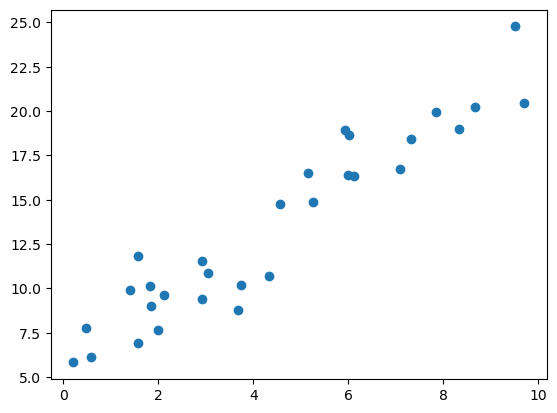

In [72]:
## Very simple examples on some synthetic data:
np.random.seed(42)

#Random points between 0 and 10, sorted:
N = 30
X = pd.DataFrame({'x':np.random.uniform(0, 10, N)})
X['x'] = X['x'].sort_values()

#Now make y
y = 2*X['x'] + 5 + np.random.normal(loc=0, scale=2, size=N)

plt.scatter(X['x'],y);

In [73]:
##Example:
from sklearn.linear_model import LinearRegression

#Initialize: Independent of Data
reg = LinearRegression()

#Fit: Learns from the data, returns self as a trained model
#Could get the returned object: reg2 = reg.fit(X, y)
reg.fit(X, y)

LinearRegression()

In [74]:
#Various methods, trainable attributes:
print(reg2.score(X, y))
print(reg.coef_)
print(reg.intercept_)

0.8844641050591624
[1.72138421]
5.857942555802445


#### Transformers

Some estimators can transform a dataset: Takes an input dataset and returns a transformed dataset.

- Transformation is performed by the `transform()` method. Transformation usually relies on learned parameters.

- All transformers have `fit_transform()` convenience method, equivalent to calling `fit()` and `transform()` in sequence. However, `fit_transform()` may be optimized to run faster.

- Examples: `StandardScaler`, `SimpleImputer`

In [75]:
##Example:
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

#Let's randomly NaN some of X:
X['x'].loc[np.random.choice(X.index, 10, replace=False)] = np.nan

#Initialize: Independent of Data
imputer = SimpleImputer(strategy='mean')
#imputer = KNNImputer(n_neighbors=5)

#Fit: Learns from the data, returns self as a trained model
imputer.fit(X)

#Transform: Gives transformed dataset with, in this case, imputed values
imputer.transform(X)


array([[3.74540119],
       [9.50714306],
       [7.31993942],
       [4.52715775],
       [1.5601864 ],
       [1.5599452 ],
       [0.58083612],
       [8.66176146],
       [6.01115012],
       [7.08072578],
       [0.20584494],
       [9.69909852],
       [4.52715775],
       [4.52715775],
       [4.52715775],
       [1.8340451 ],
       [4.52715775],
       [5.24756432],
       [4.52715775],
       [4.52715775],
       [6.11852895],
       [1.39493861],
       [4.52715775],
       [4.52715775],
       [4.56069984],
       [7.85175961],
       [1.99673782],
       [5.14234438],
       [4.52715775],
       [0.46450413]])

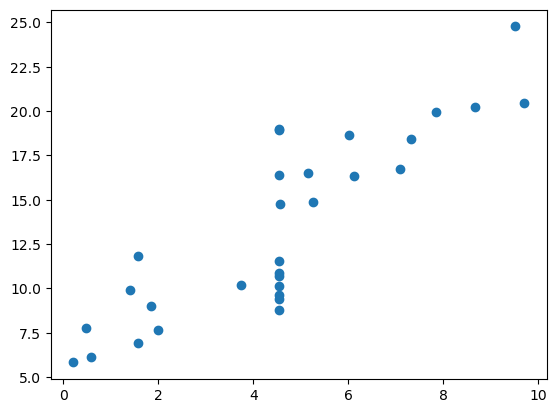

In [76]:
#Back to DataFrame:
X = pd.DataFrame(imputer.transform(X), columns = X.columns,
                              index = X.index)

plt.scatter(X['x'], y)

#### Predictors

Some estimators, once trained on a dataset, can make predictions. A predictor has a `predict()` method: Takes a (potentially new) dataset and returns predictions. Typically labels for supervised learning, or say, cluster membership for an unsupervised clustering method. Also has a `score()` method that returns a numeric value quantifying the quality of the predictions.


In [77]:
##Example:
from sklearn.linear_model import LinearRegression

#Initialize: Independent of Data
reg = LinearRegression()

#Fit: Learns from the data, returns self as a trained model
reg.fit(X, y)

#Predict on a new dataset
#Just copy for convenience
X_test = X.copy()
y_test = y.copy()
reg.predict(X_test)

#Score on this new dataset
reg.score(X_test, y_test)


0.7359586338370867

#### Inspection

- All the estimator's hyperparameters are accessible directly via public instance variables (e.g. `imputer.strategy`).
- All the estimator's learned parameters are acessible via public instance variables with an underscore suffix (e.g. `imputer.statistics_`)

#### Non-proliferation of classes

 Datasets are represented as NumPy array 
or SciPy sparse matrices. Hyper-parameter names and values are represented as standard Python strings or numbers whenever possible.

#### Composition

Existing building blocks are reused as much as possible: on. Many machine learning tasks are expressible as sequence  or
combinations of transformations to data. Some learning algorithms are also naturally viewed as meta-algorithms parametrized on other algorithms. Whenever feasible, such algorithms are implemented and composed from existing building blocks.

#### Sensible defaults

Reasonable default parameters are provided for most parameters. library. The default value should cause the operation to be performed in a sensible way, making it easy to quickly create a working baseline system, and making most estimators work reasonably well out-of-the-box.


## Some more advanced ML Workflow stuff

- Set up pipelines for several transformations in sequence
- Use ColumnTransformers
- More Transformations

In [78]:
from sklearn.model_selection import train_test_split

#Read in our data with pandas
housing = pd.read_csv("Data/housing/housing.csv")

#And categorize by income for statified split:
#####
housing['income_cat'] = pd.cut(housing['median_income'],
                               bins = [0, 1.5, 3, 4.5, 6, np.inf],
                               labels = [1, 2, 3, 4, 5])

#Divide our features and our labels:
#Also drop income_cat:
#####
X = housing[housing.columns.difference(['median_house_value', 'income_cat'])]
y = housing['median_house_value']


#Do a stratified train/test split:
#####
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42, stratify = housing['income_cat'])

In [79]:
#Take a look:
X_train

,households,housing_median_age,latitude,longitude,median_income,ocean_proximity,population,total_bedrooms,total_rooms
13096,1034.0,52.0,37.80,-122.42,2.0987,NEAR BAY,1576.0,1115.0,3321.0
14973,357.0,40.0,34.14,-118.38,6.0876,<1H OCEAN,666.0,354.0,1965.0
3785,203.0,33.0,38.36,-121.98,2.4330,INLAND,562.0,217.0,1083.0
14689,780.0,17.0,33.75,-117.11,2.2618,INLAND,1845.0,851.0,4174.0
20507,1172.0,36.0,33.77,-118.15,3.5292,NEAR OCEAN,1912.0,1211.0,4366.0
...,...,...,...,...,...,...,...,...,...
14207,523.0,41.0,33.86,-118.40,4.7105,<1H OCEAN,938.0,597.0,2237.0
13105,532.0,23.0,36.32,-119.31,2.5733,INLAND,1419.0,592.0,2945.0
19301,760.0,13.0,32.59,-117.06,4.0616,NEAR OCEAN,2814.0,775.0,3920.0
19121,838.0,37.0,34.06,-118.40,4.1455,<1H OCEAN,1725.0,873.0,3781.0


In [80]:
#And note:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 13096 to 19888
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   households          16512 non-null  float64
 1   housing_median_age  16512 non-null  float64
 2   latitude            16512 non-null  float64
 3   longitude           16512 non-null  float64
 4   median_income       16512 non-null  float64
 5   ocean_proximity     16512 non-null  object 
 6   population          16512 non-null  float64
 7   total_bedrooms      16344 non-null  float64
 8   total_rooms         16512 non-null  float64
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


## What Needs Doing?

1. Imputation for missing data
2. Rescaling (standardization) of numeric features
3. One-hot encoding of categorical feature

### 1. Set up an imputation-rescaling pipeline for numeric variables

- We do this for the numeric features

In [81]:
#Get our numeric columns first:
#####
X_train_numeric = X_train.select_dtypes(include=[np.number])

X_train_numeric

,households,housing_median_age,latitude,longitude,median_income,population,total_bedrooms,total_rooms
13096,1034.0,52.0,37.80,-122.42,2.0987,1576.0,1115.0,3321.0
14973,357.0,40.0,34.14,-118.38,6.0876,666.0,354.0,1965.0
3785,203.0,33.0,38.36,-121.98,2.4330,562.0,217.0,1083.0
14689,780.0,17.0,33.75,-117.11,2.2618,1845.0,851.0,4174.0
20507,1172.0,36.0,33.77,-118.15,3.5292,1912.0,1211.0,4366.0
...,...,...,...,...,...,...,...,...
14207,523.0,41.0,33.86,-118.40,4.7105,938.0,597.0,2237.0
13105,532.0,23.0,36.32,-119.31,2.5733,1419.0,592.0,2945.0
19301,760.0,13.0,32.59,-117.06,4.0616,2814.0,775.0,3920.0
19121,838.0,37.0,34.06,-118.40,4.1455,1725.0,873.0,3781.0


In [82]:
##Recall some imputers we could use:
#######
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer



In [83]:
#Our standard scaler:
# Recall this subtracts mean and divides by standard deviation
# Can also use MinMax scaler
from sklearn.preprocessing import StandardScaler


In [84]:
### Now: We need an imputer, and a scaler:
from sklearn.pipeline import make_pipeline

num_pipeline = make_pipeline(KNNImputer(n_neighbors=10), StandardScaler())

#We got?
num_pipeline

Pipeline(steps=[('knnimputer', KNNImputer(n_neighbors=10)),
                ('standardscaler', StandardScaler())])

In [85]:
#Can index our pipeline:
num_pipeline[0]

KNNImputer(n_neighbors=10)

- Call `fit()` on pipeline to sequentially fit and apply all transformers: calls `fit_transform()` for all transformers except last. Calls `fit()` on last.
- Call also call `fit_transform()`

In [86]:
#Let's call and look:
numeric_prepared = num_pipeline.fit_transform(X_train_numeric)
numeric_prepared

array([[ 1.39481249,  1.86111875,  1.0136059 , ...,  0.13746004,
         1.36073757,  0.31191221],
       [-0.37348471,  0.90762971, -0.702103  , ..., -0.69377062,
        -0.43643778, -0.30861991],
       [-0.77572662,  0.35142777,  1.27611874, ..., -0.78876841,
        -0.75997657, -0.71224036],
       ...,
       [ 0.67913534, -1.23772062, -1.42870103, ...,  1.26829911,
         0.55779458,  0.58602632],
       [ 0.88286825,  0.66925745, -0.73960483, ...,  0.27356264,
         0.78923109,  0.52241721],
       [-0.75221898,  1.22545939,  0.94797769, ..., -0.67915557,
        -0.81193171, -1.01060831]])

In [87]:
## Convert back to DataFrame:
#####
X_train_numeric_prepared = pd.DataFrame(numeric_prepared,
                                        #columns = X_train_numeric.columns, #OR:
                                        columns = num_pipeline.get_feature_names_out(),
                                        index=X_train_numeric.index)

X_train_numeric_prepared

,households,housing_median_age,latitude,longitude,median_income,population,total_bedrooms,total_rooms
13096,1.394812,1.861119,1.013606,-1.423037,-0.936491,0.137460,1.360738,0.311912
14973,-0.373485,0.907630,-0.702103,0.596394,1.171942,-0.693771,-0.436438,-0.308620
3785,-0.775727,0.351428,1.276119,-1.203098,-0.759789,-0.788768,-0.759977,-0.712240
14689,0.731375,-0.919891,-0.884924,1.231216,-0.850281,0.383175,0.737276,0.702262
20507,1.755263,0.589800,-0.875549,0.711362,-0.180365,0.444376,1.587451,0.790125
...,...,...,...,...,...,...,...,...
14207,0.060101,0.987087,-0.833359,0.586397,0.444041,-0.445315,0.137430,-0.184147
13105,0.083608,-0.443146,0.319822,0.131525,-0.685630,-0.005950,0.125622,0.139847
19301,0.679135,-1.237721,-1.428701,1.256209,0.101049,1.268299,0.557795,0.586026
19121,0.882868,0.669257,-0.739605,0.586397,0.145396,0.273563,0.789231,0.522417


### 2. Set up an imputer->one-hot encoding pipeline for the categorical variable

- We'll use `most_frequent` for categorical imputation
- Followed by one-hot encoding

In [88]:
from sklearn.preprocessing import OneHotEncoder

#Impute any missing values with most_frequent
#Ignore any unknown category

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore", sparse_output=False))

cat_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

In [90]:
#Similar for categorical:
X_train_cat = X_train[['ocean_proximity']]

#sparse_output=False above yields dense array 
cat_prepared = cat_pipeline.fit_transform(X_train_cat)
cat_prepared

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [91]:
## Back to pandas:
X_train_cat_prepared = pd.DataFrame(cat_prepared,
                         columns = cat_pipeline.get_feature_names_out(),
                         index = X_train.index)

X_train_cat_prepared

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
13096,0.0,0.0,0.0,1.0,0.0
14973,1.0,0.0,0.0,0.0,0.0
3785,0.0,1.0,0.0,0.0,0.0
14689,0.0,1.0,0.0,0.0,0.0
20507,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...
14207,1.0,0.0,0.0,0.0,0.0
13105,0.0,1.0,0.0,0.0,0.0
19301,0.0,0.0,0.0,0.0,1.0
19121,1.0,0.0,0.0,0.0,0.0


#### Can then merge the numeric and categorical:

- We'd like a single training DataFrame: Merge the numeric and categorical on the index

In [92]:
#Now we have lovely data prepared for machine learning:
#######

X_train_prepared = X_train_numeric_prepared.merge(X_train_cat_prepared, left_index=True, right_index=True)
X_train_prepared


,households,housing_median_age,latitude,longitude,median_income,population,total_bedrooms,total_rooms,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
13096,1.394812,1.861119,1.013606,-1.423037,-0.936491,0.137460,1.360738,0.311912,0.0,0.0,0.0,1.0,0.0
14973,-0.373485,0.907630,-0.702103,0.596394,1.171942,-0.693771,-0.436438,-0.308620,1.0,0.0,0.0,0.0,0.0
3785,-0.775727,0.351428,1.276119,-1.203098,-0.759789,-0.788768,-0.759977,-0.712240,0.0,1.0,0.0,0.0,0.0
14689,0.731375,-0.919891,-0.884924,1.231216,-0.850281,0.383175,0.737276,0.702262,0.0,1.0,0.0,0.0,0.0
20507,1.755263,0.589800,-0.875549,0.711362,-0.180365,0.444376,1.587451,0.790125,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14207,0.060101,0.987087,-0.833359,0.586397,0.444041,-0.445315,0.137430,-0.184147,1.0,0.0,0.0,0.0,0.0
13105,0.083608,-0.443146,0.319822,0.131525,-0.685630,-0.005950,0.125622,0.139847,0.0,1.0,0.0,0.0,0.0
19301,0.679135,-1.237721,-1.428701,1.256209,0.101049,1.268299,0.557795,0.586026,0.0,0.0,0.0,0.0,1.0
19121,0.882868,0.669257,-0.739605,0.586397,0.145396,0.273563,0.789231,0.522417,1.0,0.0,0.0,0.0,0.0


## Do All Together with a `ColumnTransformer`

- We can combine everything...

In [94]:
from sklearn.compose import ColumnTransformer

#Make a list of the numeric attributes
#Could also list out manually
num_attribs = list(X_train.select_dtypes(include=[np.number]).columns)

#And categorical:
cat_attribs = ["ocean_proximity"]


#The pipeline for numeric:
num_pipeline = make_pipeline(
    KNNImputer(n_neighbors=10),
    StandardScaler())

#And categorical:
cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore", sparse_output=False)) #Don't necessarily need sparse_output=False

#Our preprocessing transformer:
########
preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

preprocessing

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('knnimputer',
                                                  KNNImputer(n_neighbors=10)),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['households', 'housing_median_age',
                                  'latitude', 'longitude', 'median_income',
                                  'population', 'total_bedrooms',
                                  'total_rooms']),
                                ('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['ocean_proximity'])])

In [99]:
## Altermative for getting the attributes and creating the column transformer
from sklearn.compose import make_column_selector, make_column_transformer

preprocessing2 = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)))

preprocessing2

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('knnimputer',
                                                  KNNImputer(n_neighbors=10)),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000026F0A964D30>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000026F0A967610>)])

In [100]:
#Can run it, using fit_transform on the training data
####
prepared_data = preprocessing.fit_transform(X_train)


In [101]:
## Get a numpy array as usual
prepared_data

array([[ 1.39481249,  1.86111875,  1.0136059 , ...,  0.        ,
         1.        ,  0.        ],
       [-0.37348471,  0.90762971, -0.702103  , ...,  0.        ,
         0.        ,  0.        ],
       [-0.77572662,  0.35142777,  1.27611874, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.67913534, -1.23772062, -1.42870103, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.88286825,  0.66925745, -0.73960483, ...,  0.        ,
         0.        ,  0.        ],
       [-0.75221898,  1.22545939,  0.94797769, ...,  0.        ,
         0.        ,  1.        ]])

In [102]:
#Feature/column names now?
preprocessing.get_feature_names_out()

array(['num__households', 'num__housing_median_age', 'num__latitude',
       'num__longitude', 'num__median_income', 'num__population',
       'num__total_bedrooms', 'num__total_rooms',
       'cat__ocean_proximity_<1H OCEAN', 'cat__ocean_proximity_INLAND',
       'cat__ocean_proximity_ISLAND', 'cat__ocean_proximity_NEAR BAY',
       'cat__ocean_proximity_NEAR OCEAN'], dtype=object)

In [103]:
#And put into DataFrame:
#######

X_train_prepared = pd.DataFrame(prepared_data,
                         columns = preprocessing.get_feature_names_out(),
                         index = X_train.index)

X_train_prepared

,num__households,num__housing_median_age,num__latitude,num__longitude,num__median_income,num__population,num__total_bedrooms,num__total_rooms,cat__ocean_proximity_<1H OCEAN,cat__ocean_proximity_INLAND,cat__ocean_proximity_ISLAND,cat__ocean_proximity_NEAR BAY,cat__ocean_proximity_NEAR OCEAN
13096,1.394812,1.861119,1.013606,-1.423037,-0.936491,0.137460,1.360738,0.311912,0.0,0.0,0.0,1.0,0.0
14973,-0.373485,0.907630,-0.702103,0.596394,1.171942,-0.693771,-0.436438,-0.308620,1.0,0.0,0.0,0.0,0.0
3785,-0.775727,0.351428,1.276119,-1.203098,-0.759789,-0.788768,-0.759977,-0.712240,0.0,1.0,0.0,0.0,0.0
14689,0.731375,-0.919891,-0.884924,1.231216,-0.850281,0.383175,0.737276,0.702262,0.0,1.0,0.0,0.0,0.0
20507,1.755263,0.589800,-0.875549,0.711362,-0.180365,0.444376,1.587451,0.790125,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14207,0.060101,0.987087,-0.833359,0.586397,0.444041,-0.445315,0.137430,-0.184147,1.0,0.0,0.0,0.0,0.0
13105,0.083608,-0.443146,0.319822,0.131525,-0.685630,-0.005950,0.125622,0.139847,0.0,1.0,0.0,0.0,0.0
19301,0.679135,-1.237721,-1.428701,1.256209,0.101049,1.268299,0.557795,0.586026,0.0,0.0,0.0,0.0,1.0
19121,0.882868,0.669257,-0.739605,0.586397,0.145396,0.273563,0.789231,0.522417,1.0,0.0,0.0,0.0,0.0


#### Easy to prep the test data too!

In [104]:
##Easy to prep the test data too:

#Use transform, NOT fit_transform!
prepared_data = preprocessing.transform(X_test)

X_test_prepared = pd.DataFrame(prepared_data,
                         columns = preprocessing.get_feature_names_out(),
                         index = X_test.index)

X_test_prepared

,num__households,num__housing_median_age,num__latitude,num__longitude,num__median_income,num__population,num__total_bedrooms,num__total_rooms,cat__ocean_proximity_<1H OCEAN,cat__ocean_proximity_INLAND,cat__ocean_proximity_ISLAND,cat__ocean_proximity_NEAR BAY,cat__ocean_proximity_NEAR OCEAN
3905,-0.415276,-0.602061,0.690153,-1.188103,2.043245,-0.468151,-0.429353,-0.115504,1.0,0.0,0.0,0.0,0.0
16821,-0.595501,0.589800,-0.819296,0.781342,0.404345,-0.567716,-0.646620,-0.480685,1.0,0.0,0.0,0.0,0.0
2900,2.619822,0.113056,-0.889612,0.696366,0.119655,0.648987,2.860352,1.498977,0.0,0.0,0.0,0.0,1.0
7193,-0.339529,1.861119,0.985480,-1.453028,0.137732,-0.322914,-0.273488,-0.216638,0.0,0.0,0.0,0.0,1.0
13928,-0.282066,-1.873380,1.004230,-1.408041,-0.140986,-0.639878,-0.056221,-0.564887,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12369,0.107116,1.384374,2.415237,-2.292791,-0.928669,-0.200513,0.137430,0.184236,0.0,0.0,0.0,0.0,1.0
8707,-0.211543,0.033598,-0.116137,0.281483,-1.079101,-0.266281,-0.188470,-0.374975,0.0,1.0,0.0,0.0,0.0
16634,-0.961176,0.351428,1.421438,-1.717953,0.431884,-0.942226,-0.925288,-0.789578,1.0,0.0,0.0,0.0,0.0
9779,-0.289902,-0.363689,0.919851,-1.228091,0.370886,0.057077,-0.367951,-0.257367,0.0,0.0,0.0,1.0,0.0


## More Transformers

Let's look at a few more transformers

#### Recall Some Typical Transformations

- Square root
- Other power
- Log-transform
- Bucketization

Look at this on `population`:

#### Log-transformation

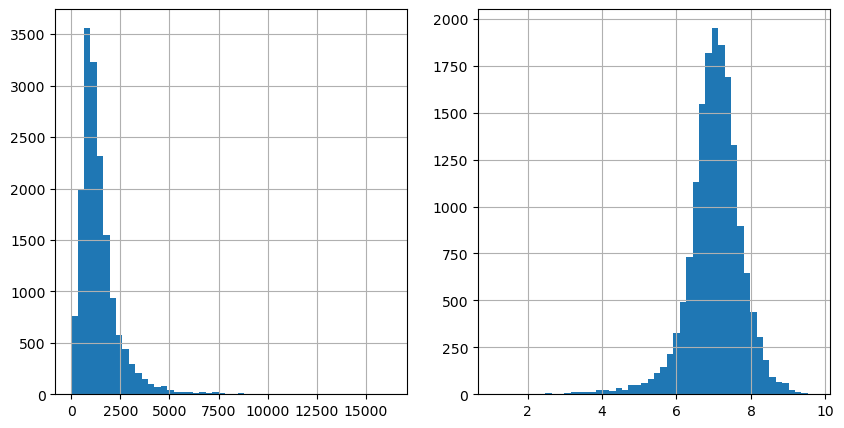

In [105]:
fig, ax1 = plt.subplots(1,2, figsize=(10,5))

X_train['population'].hist(ax=ax1[0], bins=50);

#With a log-transformation, it is nearly Gaussian
np.log(X_train['population']).hist(ax=ax1[1], bins=50);


#### Bucketization

1. Divide distribution intro (roughly) equal-size buckets
2. Replace feature value of the index of the bucket it belongs to
3. For example, replace with percentile
4. Converts to (nearly) uniform distribution
5. We'll use `pd.cut`, similar to when we categorized based on income

Text(0, 0.5, 'Number of districts')

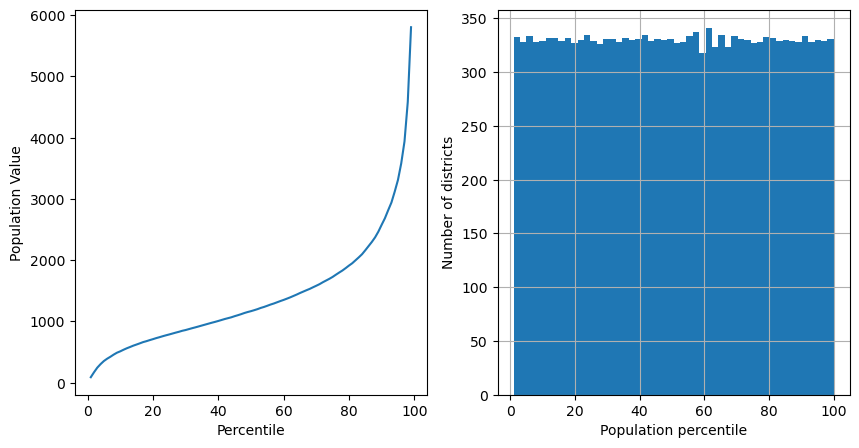

In [106]:
# Example: Percentile + Population
# Partly adapted from the book code
percentiles = [np.percentile(X_train["population"], i) for i in range(1, 100)]

bucket_population = pd.cut(X_train["population"],
                                 bins=[-np.inf] + percentiles + [np.inf],
                                 labels=range(1, 100 + 1))

fig, ax1 = plt.subplots(1,2, figsize=(10,5))

#Plot the percentiles:
ax1[0].plot(range(1,100), percentiles)
ax1[0].set_xlabel("Percentile")
ax1[0].set_ylabel("Population Value")

#And the bucketized/flattened population:
bucket_population.hist(bins=50, ax=ax1[1])
ax1[1].set_xlabel("Population percentile")
ax1[1].set_ylabel("Number of districts")


Text(0.5, 1.0, 'Bucketed/Flattened Population')

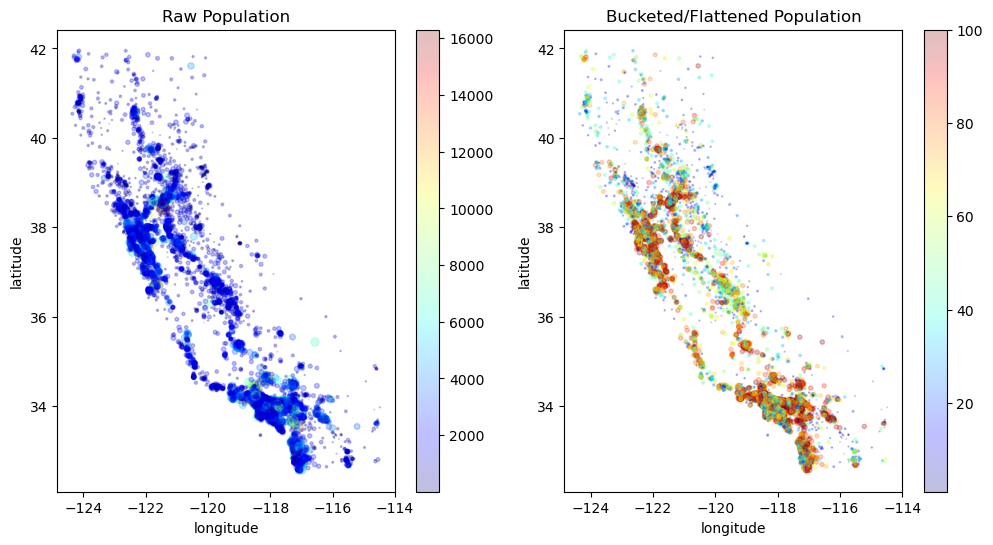

In [107]:
##Compare raw vs. bucket population spatially:
#########
fig, ax1 = plt.subplots(1,2, figsize=(12, 6))

#Unaltered population:
X_train.plot(kind='scatter', x='longitude', y='latitude', alpha=.25, grid=False, ax=ax1[0],
                  s = X_train['population'] / 200, c = X_train['population'], cmap='jet')
ax1[0].set_title('Raw Population')

#Bucketized:
X_train.plot(kind='scatter', x='longitude', y='latitude', alpha=.25, grid=False, ax=ax1[1],
                  s = bucket_population.astype(int)/10, c = bucket_population.astype(int), cmap='jet')
ax1[1].set_title('Bucketed/Flattened Population')


#### Dealing with multi-modal distributions

Example of `housing_median_age`

Options:
- Can do nothing
- Can bucket
- Can bucket + encode as categorical (e.g. one-hot encoding)
    - Why? Suppose variable is house age, and a particular style of house built, say, 35 years ago, is now quite unfashionable, but a style built 50 years ago is quite in vogue.
 
Another option is feature for each mode, representing similarity between feature value and that mode
- Similarity measure computed using *Radial Basis Function* (RBF)
- Typically Gaussian RBF

Let $x$ be housing age, and compare to age of $35$; Gaussian RBF similarity is:

$$
\exp(-\gamma (x - 35)^2)
$$

In [108]:
## Example using scikit-learn:
#######

from sklearn.metrics.pairwise import rbf_kernel

age_similarity_35 = rbf_kernel(X_train[['housing_median_age']], [[35]], gamma=.1)

In [109]:
#For display purposes only:
#Try changing gammga
age_similarity_35_disp = rbf_kernel(X_train[['housing_median_age']].sort_values(by='housing_median_age'), [[35]], gamma=.01)

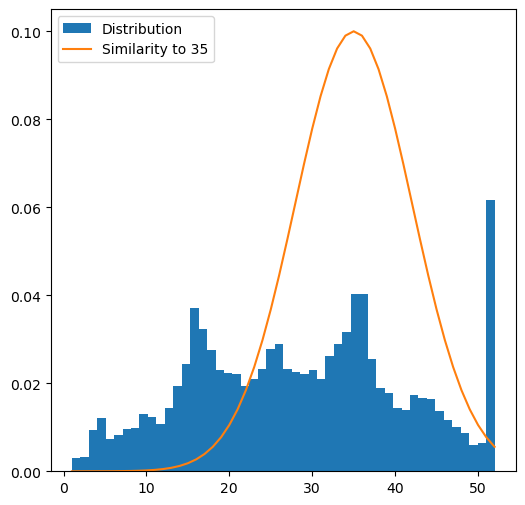

In [110]:
#Plot distribution + age_similarity_35 (display version)
#####
fig, ax1 = plt.subplots(1,1, figsize=(6,6))

#Distribution
ax1.hist(X_train[['housing_median_age']], bins=50, density=True, label='Distribution')

#Similarity to 35
ax1.plot(X_train[['housing_median_age']].sort_values(by='housing_median_age'), age_similarity_35_disp / 10, label='Similarity to 35')

ax1.legend()

## And Now, Some Custom Transformers

- We will come back to adding these into the pipeline
- Let's define some transformations for skew data, etc.
- Start with a custom log-transformer:

In [111]:
from sklearn.preprocessing import FunctionTransformer

#Optionally can define an inverse function:
log_transformer = FunctionTransformer(np.log, inverse_func = np.exp)

array([[<Axes: title={'center': 'population'}>]], dtype=object)

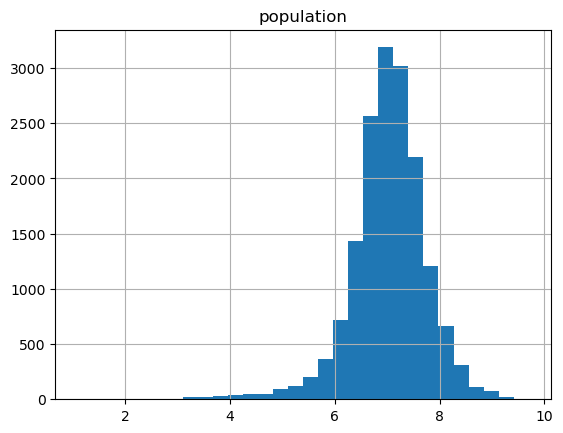

In [112]:
##Give it a try on population:
log_pop = log_transformer.transform(X_train[['population']])
log_pop.hist(bins=30)

### Wrap RBF in a custom transformer, pass optional arguments


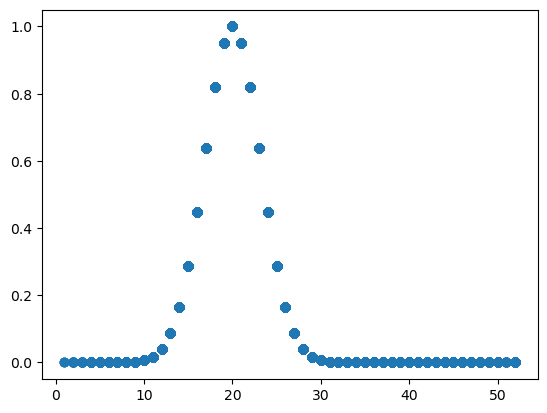

In [113]:
from sklearn.metrics.pairwise import rbf_kernel

rbf_transformer = FunctionTransformer(rbf_kernel,
                                      kw_args=dict(Y=[[20.]], gamma=.05))
                                      
age_simil = rbf_transformer.transform(X_train[["housing_median_age"]])

#Quick check:
plt.scatter(X_train[["housing_median_age"]], age_simil)

Text(0.5, 1.0, 'Similary to San Francisco')

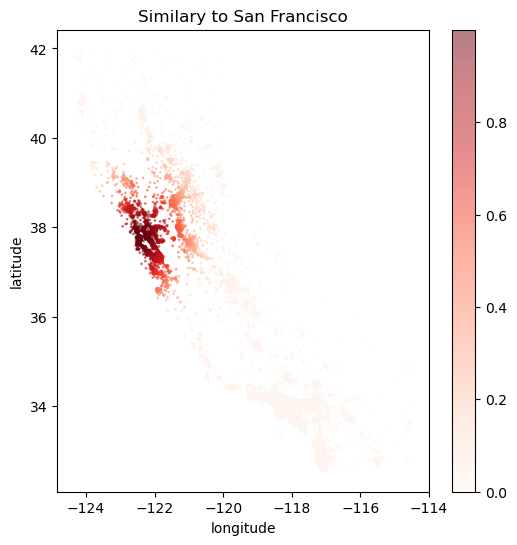

In [115]:
## Could do geographic similarity to San Francisco:
########
#Lat/Lon for San Francisco
sf_coords = 37.7749, -122.41
sf_transformer = FunctionTransformer(rbf_kernel,
                                     kw_args=dict(Y=[sf_coords], gamma=0.5))

sf_simil = sf_transformer.transform(X_train[["latitude", "longitude"]])
                                      
fig, ax1 = plt.subplots(1,1, figsize=(6, 6))

#Color by similarity to San Francisco L/L
X_train.plot(kind='scatter', x='longitude', y='latitude', alpha=.5, grid=False, ax=ax1,
                  s = 1, c = sf_simil, cmap='Reds')
ax1.set_title('Similary to San Francisco')


### Trainable Transformer?

- That is, transformer learns some parameters when `fit()` is called, uses when `fit_transform()` is called

- Define a class with three methods:
    1. `fit()` (must return `self`)
    2. `transform()`
    3. `fit_transform()`

Can use `TransformerMixin` as base class (don't have to)
    - Inherits `fit_transform()`: Just calls `fit()` and `transform()` in sequence

Add `BaseEstimator` as base class:
    - Gives `get_params()` and `set_params()` methods

Define our own version of the StandardScaler:

In [148]:
#Taken almost directly from our book code source:
#########

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True):  # with_mean = True indicates we should subtract off the mean, otherwise just divide by stddev alone
        self.with_mean = with_mean

    def fit(self, X, y=None): #y is required even though it isn't used

        #Extract feature names from columns:
        if (isinstance(X, pd.DataFrame)):
            self.feature_names = np.array(X.columns)
        #If no columns, just 0 through n
        else:
            self.feature_names = np.array(range(0, X.shape[1])).astype(str)
                                          
        X = check_array(X)  # checks that X is an array with finite float values

        #Get mean and stddev
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        
        self.n_features_in_ = X.shape[1]  # every estimator stores this in fit()

        return self  # always return self!

    def transform(self, X):
        check_is_fitted(self)  # looks for learned attributes (with trailing _)
        X = check_array(X)

        #Check that input shape matches n_features_in_
        assert self.n_features_in_ == X.shape[1]
        
        #If subtracting off mean?
        if self.with_mean:
            X = X - self.mean_

        #Divide by standard deviation regardless
        return X / self.scale_

    def get_feature_names_out(self, names=None):
        #Just return the feature names used to create:
        return self.feature_names

In [149]:
##Try it out:

standard_scaler_clone = StandardScalerClone()

#Use X_train_numeric from above:
#just fill NaNs with 0 for expediency

X_train_numeric_scaled = standard_scaler_clone.fit_transform(X_train_numeric.fillna(0))
X_train_numeric_scaled

array([[ 1.39481249,  1.86111875,  1.0136059 , ...,  0.13746004,
         1.36786   ,  0.31191221],
       [-0.37348471,  0.90762971, -0.702103  , ..., -0.69377062,
        -0.42213121, -0.30861991],
       [-0.77572662,  0.35142777,  1.27611874, ..., -0.78876841,
        -0.74437667, -0.71224036],
       ...,
       [ 0.67913534, -1.23772062, -1.42870103, ...,  1.26829911,
         0.56812674,  0.58602632],
       [ 0.88286825,  0.66925745, -0.73960483, ...,  0.27356264,
         0.79863809,  0.52241721],
       [-0.75221898,  1.22545939,  0.94797769, ..., -0.67915557,
        -0.79612411, -1.01060831]])

In [150]:
#Get feature names:
standard_scaler_clone.get_feature_names_out()

array(['households', 'housing_median_age', 'latitude', 'longitude',
       'median_income', 'population', 'total_bedrooms', 'total_rooms'],
      dtype=object)

### Cluster Similarity Transformer:

This is a cool example from the book. Two steps:

1. Use K-Means clustering algorithm to get clusters/cluster centers
2. Use the `rbf_kernel` transformer to get similarity to cluster center

Unlike the book, we'll start with a ClusterMembership transformer...

In [117]:
#Adopted partly from the book code:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans

#Define a class that defines the cluster membership
#We'll inherit this class for Cluster similarity
class ClusterMembership(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, random_state=42):
        self.n_clusters = n_clusters
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None): #sample_weight weights observations for clustering algorithm
        #Make a K-Means clusterer
        self.kmeans_ = KMeans(n_clusters=self.n_clusters, n_init=10, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        
        return self #Always return self

    def transform(self, X):
        #Get cluster labels:
        return self.kmeans_.labels_

    #Return the cluster centers:
    def get_cluster_centers(self):
        return self.kmeans_.cluster_centers_

    def get_feature_names_out(self, names=None):
        return np.array([f"Cluster {i}" for i in range(self.n_clusters)])

In [118]:
##Let's add a background map for this:
#url_state = 'https://www2.census.gov/geo/tiger/GENZ2021/shp/cb_2021_us_state_500k.zip'
#url_county = 'https://www2.census.gov/geo/tiger/GENZ2021/shp/cb_2021_us_county_500k.zip'
fp_state = 'Data/cb_2021_us_state_500k.zip'
fp_county = 'Data/cb_2021_us_county_500k.zip'

#And grab:
state_gdf = gpd.read_file(fp_state)
county_gdf = gpd.read_file(fp_county)

#Also, exclude anything outside the CONUS:
#Hawaii = 15, Alasksa = 02, Puerto Rico = 72
#Guam = 66, Northern Mariana Islands = 69, American Samoa = 60, Virgin Islands = 78
exclude_list = ['15', '72', '02', '60', '66', '69', '78']

#~ is not
state_gdf = state_gdf.loc[~state_gdf['STATEFP'].isin(exclude_list)]
county_gdf = county_gdf.loc[~county_gdf['STATEFP'].isin(exclude_list)]


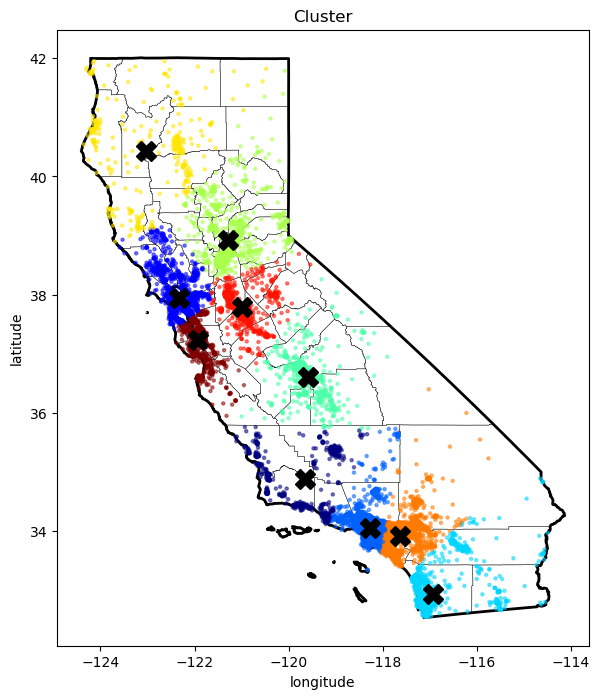

In [119]:
##Clusters
kmeans_transformer = ClusterMembership(n_clusters = 10)

cluster_label = kmeans_transformer.fit_transform(X_train[['latitude', 'longitude']])
                                      
fig, ax1 = plt.subplots(1,1, figsize=(8, 8))


#California Background:
#06 is State FIPS code for California
state_gdf.loc[state_gdf.STATEFP == '06'].plot(ax=ax1, facecolor='none', linewidth=2)
county_gdf.loc[county_gdf.STATEFP == '06'].plot(ax=ax1, facecolor='none', linewidth=.25)


#Plot cluster membership:
X_train.plot(kind='scatter', x='longitude', y='latitude', alpha=.5, grid=False, ax=ax1,
                  s = 5, c = cluster_label, cmap='jet', colorbar=False)
ax1.set_title('Cluster')

ax1.plot(kmeans_transformer.kmeans_.cluster_centers_[:, 1], #longitude
         kmeans_transformer.kmeans_.cluster_centers_[:, 0], #latitude
         linestyle="", color="black", marker="X", markersize=15,
         label="Cluster centers")


In [125]:
#Adopted partly from the book code:
#Inherit ClusterMembership

class ClusterSimilarity(ClusterMembership):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=42):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state
        
    #Inherited fit
    #Could redefine here:
    
    #def fit(self, X, y=None, sample_weight=None): #sample_weight weights observations for clustering algorithm
    #    #Make a K-Means clusterer
    #    self.kmeans_ = KMeans(n_clusters=self.n_clusters, n_init=10, random_state=self.random_state)
    #    self.kmeans_.fit(X, sample_weight=sample_weight)
        
    #    return self #Always return self
        
    def transform(self, X):
        #Get similarity to cluster centers:
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return np.array([f"Cluster {i} similarity" for i in range(self.n_clusters)])

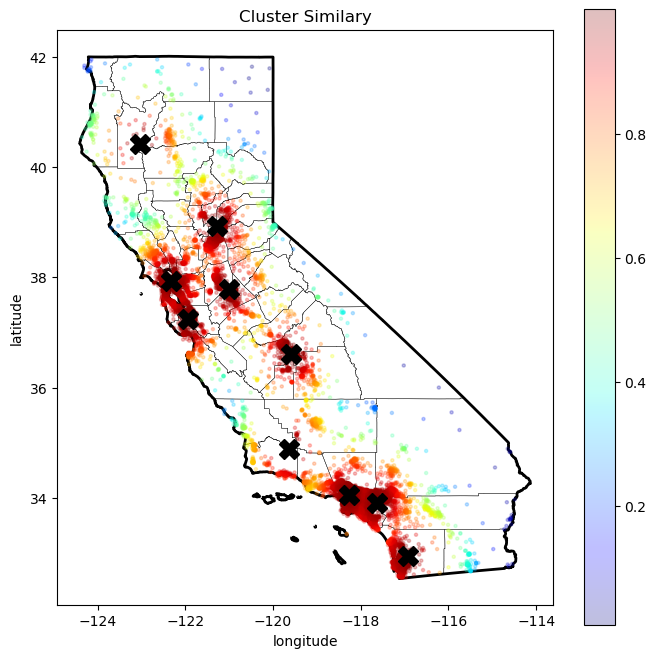

In [126]:
##Cluster similarities
cluster_similarity = ClusterSimilarity(n_clusters = 10, gamma=.5)

similarities = cluster_similarity.fit_transform(X_train[['latitude', 'longitude']])
#Have multiple similaries
#Get the max:
max_similarity = similarities.max(axis=1)


fig, ax1 = plt.subplots(1,1, figsize=(8, 8))

#California Background:
#06 is State FIPS code for California
state_gdf.loc[state_gdf.STATEFP == '06'].plot(ax=ax1, facecolor='none', linewidth=2)
county_gdf.loc[county_gdf.STATEFP == '06'].plot(ax=ax1, facecolor='none', linewidth=.25)


#Plot cluster membership:
X_train.plot(kind='scatter', x='longitude', y='latitude', alpha=.25, grid=False, ax=ax1,
                  s = 5, c = max_similarity, cmap='jet')
ax1.set_title('Cluster Similary')

ax1.plot(cluster_similarity.kmeans_.cluster_centers_[:, 1], #longitude
         cluster_similarity.kmeans_.cluster_centers_[:, 0], #latitude
         linestyle="", color="black", marker="X", markersize=15,
         label="Cluster centers")


## Put Everything in the Pipe!

Let's make a single pipeline to perform all our data transformations, and finally train some models.

Recall transformations:

1. Impute missing values: Treat numerical and categorical variables differently
2. One-hot encode categorical features
3. Compute some derived **ratio** variables: `bedrooms_ratio`, `rooms_per_house`, and `people_per_house`
4. Add cluster similarity features
5. Log-transform features with long tails, as most ML model like roughly uniform or Gaussian inputs
6. Standardize all numerical features

Here we go:

In [127]:
## First we need to define all our custom transformers and pipelines

#Inputs get concatenated into a single X
def column_ratio(X):
    #Uncomment to see:
    #print(X)
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]  # feature names out

#Function to return a pipeline for all the ratio variables:
ratio_pipeline = make_pipeline(
        SimpleImputer(strategy="median"), #Start with simple median imputation
        FunctionTransformer(column_ratio, feature_names_out=ratio_name), #Create the ratio variable using FunctionTransformer
        StandardScaler()) #And apply the StandardScaler

#Make a pipeline for log-transforming variables
log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"), #Imputation
    FunctionTransformer(np.log, feature_names_out="one-to-one"), #Take the natural log; "one-to-one" keeps name but with prefix
    StandardScaler()) #Scale

#And cluster similarities from above:
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)

#And a pipeline for any other numeric variable that doesn't get dealt with by the above
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())

#Preprocessing Column Transformer:
#Recall format: (name of transformer, pipeline, attributes)
preprocessing = ColumnTransformer([
        ("bedrooms_ratio", ratio_pipeline, ["total_bedrooms", "total_rooms"]),  #Ratio of bedrooms to rooms
        ("rooms_per_house", ratio_pipeline, ["total_rooms", "households"]), #Ratio of rooms to households
        ("people_per_house", ratio_pipeline, ["population", "households"]), #Ratio of population to households
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population", #Log transform these five variables that are long-tailed
                               "households", "median_income"]),
        ("geo", cluster_simil, ["latitude", "longitude"]), #Convert latitude and longitude to cluster similarities
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)), #Categorical variables
        #("keep", default_num_pipeline, ["population", "households"]), #If we wanted to keep population and households untransformed
    ],
    remainder=default_num_pipeline)  # one column remaining: housing_median_age

preprocessing

ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                             SimpleImputer(strategy='median')),
                                            ('standardscaler',
                                             StandardScaler())]),
                  transformers=[('bedrooms_ratio',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('functiontransformer',
                                                  FunctionTransformer(feature_names_out=<function ratio_name at 0x0000026F10AF9F30>,
                                                                      func=<function co...
                                 ['total_bedrooms', 'total_rooms', 'population',
                                  'households', 'median_income']),
                                ('geo', ClusterSimilarity(),
                                 ['latitude', 'longitude']),
                                ('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000026F10B03C70>)])

In [128]:
#Get the data as a numpy array:
prepared_data = preprocessing.fit_transform(X_train)

preprocessing.get_feature_names_out()

array(['bedrooms_ratio__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'], dtype=object)

In [129]:
#To DataFrame:
########
X_train_prepared = pd.DataFrame(prepared_data,
                         columns = preprocessing.get_feature_names_out(),
                         index = X_train.index)

X_train_prepared

,bedrooms_ratio__ratio,rooms_per_house__ratio,people_per_house__ratio,log__total_bedrooms,log__total_rooms,log__population,log__households,log__median_income,geo__Cluster 0 similarity,geo__Cluster 1 similarity,...,geo__Cluster 6 similarity,geo__Cluster 7 similarity,geo__Cluster 8 similarity,geo__Cluster 9 similarity,cat__ocean_proximity_<1H OCEAN,cat__ocean_proximity_INLAND,cat__ocean_proximity_ISLAND,cat__ocean_proximity_NEAR BAY,cat__ocean_proximity_NEAR OCEAN,remainder__housing_median_age
13096,1.846624,-0.866027,-0.330204,1.324114,0.637892,0.456906,1.310369,-1.071522,8.708837e-08,9.712456e-01,...,7.114441e-04,3.070969e-17,1.314047e-01,5.740031e-01,0.0,0.0,0.0,1.0,0.0,1.861119
14973,-0.508121,0.024550,-0.253616,-0.252671,-0.063576,-0.711654,-0.142030,1.194712,1.181328e-01,9.738096e-14,...,3.045359e-27,5.437838e-01,1.735342e-09,2.275194e-10,1.0,0.0,0.0,0.0,0.0,0.907630
3785,-0.202155,-0.041193,-0.051041,-0.925266,-0.859927,-0.941997,-0.913030,-0.756981,2.295286e-08,7.457782e-01,...,4.750719e-03,1.605970e-17,2.744847e-01,2.839978e-01,0.0,1.0,0.0,0.0,0.0,0.351428
14689,-0.149006,-0.034858,-0.141475,0.952773,0.943475,0.670700,0.925373,-0.912253,4.618947e-04,3.873884e-20,...,2.916178e-35,7.405721e-01,2.243339e-14,4.218649e-16,0.0,1.0,0.0,0.0,0.0,-0.919891
20507,0.963208,-0.666554,-0.306148,1.437622,1.003590,0.719093,1.481464,0.034537,3.166634e-02,7.905346e-16,...,2.843975e-30,7.501278e-01,2.890866e-11,3.710912e-12,0.0,0.0,0.0,0.0,1.0,0.589800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14207,0.804368,-0.452111,-0.269780,0.465581,0.109720,-0.247054,0.379471,0.648953,7.592469e-02,1.255430e-14,...,1.004491e-28,5.539064e-01,2.304608e-10,4.272885e-11,1.0,0.0,0.0,0.0,0.0,0.987087
13105,-0.192328,0.036792,-0.073741,0.454022,0.477277,0.314542,0.402773,-0.637675,1.122830e-01,8.422138e-06,...,4.942583e-14,1.831519e-04,6.702758e-03,4.498431e-04,0.0,1.0,0.0,0.0,0.0,-0.443146
19301,-0.242492,-0.109987,0.158542,0.824206,0.859552,1.243381,0.889897,0.333540,6.789654e-06,3.595707e-25,...,7.917098e-43,1.250634e-01,3.348665e-19,2.064542e-20,0.0,0.0,0.0,0.0,1.0,-1.237721
19121,0.259775,-0.360937,-0.210332,0.987851,0.811293,0.579462,1.023329,0.377051,1.096450e-01,6.165959e-14,...,1.332778e-27,5.435921e-01,1.066970e-09,1.586255e-10,1.0,0.0,0.0,0.0,0.0,0.669257


In [130]:
##And same for test data: Only use transform!
#######

#Get the data as a numpy array:
prepared_data_test = preprocessing.transform(X_test)

#To DataFrame:
########
X_test_prepared = pd.DataFrame(prepared_data_test,
                         columns = preprocessing.get_feature_names_out(),
                         index = X_test.index)

X_test_prepared

,bedrooms_ratio__ratio,rooms_per_house__ratio,people_per_house__ratio,log__total_bedrooms,log__total_rooms,log__population,log__households,log__median_income,geo__Cluster 0 similarity,geo__Cluster 1 similarity,...,geo__Cluster 6 similarity,geo__Cluster 7 similarity,geo__Cluster 8 similarity,geo__Cluster 9 similarity,cat__ocean_proximity_<1H OCEAN,cat__ocean_proximity_INLAND,cat__ocean_proximity_ISLAND,cat__ocean_proximity_NEAR BAY,cat__ocean_proximity_NEAR OCEAN,remainder__housing_median_age
3905,-0.971119,0.605653,-0.071469,-0.241073,0.196474,-0.283703,-0.204654,1.704657,3.330519e-05,4.384762e-01,...,5.373071e-06,2.939599e-13,2.527650e-01,9.830373e-01,1.0,0.0,0.0,0.0,0.0,-0.602061
16821,-0.710635,0.155747,-0.008995,-0.650631,-0.347475,-0.456183,-0.513420,0.614752,2.630798e-02,6.464388e-16,...,3.466213e-30,8.671948e-01,3.306645e-11,2.862296e-12,1.0,0.0,0.0,0.0,0.0,0.589800
2900,1.243003,-0.584891,-0.353317,1.943608,1.409472,0.869390,1.821194,0.351904,3.234274e-02,7.891931e-16,...,2.551520e-30,7.197158e-01,2.689102e-11,3.773852e-12,0.0,0.0,0.0,0.0,1.0,0.113056
7193,-0.279014,0.160464,-0.022139,-0.007937,0.066606,-0.065899,-0.093182,0.369595,8.795225e-08,9.370931e-01,...,5.543907e-04,2.736880e-17,1.100775e-01,5.747135e-01,0.0,0.0,0.0,0.0,1.0,1.861119
13928,2.312850,-0.721359,-0.257219,0.262524,-0.511980,-0.596499,-0.014298,0.078992,1.154932e-07,9.703786e-01,...,6.169377e-04,4.774931e-17,1.429945e-01,6.037729e-01,0.0,0.0,0.0,1.0,0.0,-1.873380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12369,-0.264461,0.070671,-0.172028,0.465581,0.520595,0.093892,0.425684,-1.056567,9.031787e-25,1.000876e-05,...,2.410113e-01,9.129868e-40,5.563518e-09,2.309837e-08,0.0,0.0,0.0,0.0,1.0,1.384374
8707,0.582235,-0.426304,-0.064957,0.104316,-0.166042,0.010379,0.076672,-1.364348,5.170852e-01,2.621084e-08,...,9.920730e-19,1.695787e-02,6.080075e-05,6.505388e-06,0.0,1.0,0.0,0.0,0.0,0.033598
16634,-0.800534,0.576222,-0.002496,-1.460519,-1.086712,-1.423814,-1.500849,0.638537,6.736454e-12,3.643112e-01,...,4.620273e-02,4.140182e-23,7.980929e-03,4.016534e-02,1.0,0.0,0.0,0.0,0.0,0.351428
9779,-0.443831,-0.039501,0.186039,-0.144459,0.010521,0.378957,-0.024791,0.585492,2.020139e-06,8.192907e-01,...,1.282566e-04,5.018881e-15,3.305798e-01,8.691031e-01,0.0,0.0,0.0,1.0,0.0,-0.363689


### And quickly Train/Test some Models...


In [131]:
#Random Forest or Decision Tree
#######
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

model = KNeighborsRegressor(n_neighbors=10)
#model = RandomForestRegressor(random_state=42)
#model = DecisionTreeRegressor(random_state=42)
#model = LinearRegression()

model.fit(X_train_prepared, y_train)

KNeighborsRegressor(n_neighbors=10)

Text(0, 0.5, 'Predicted')

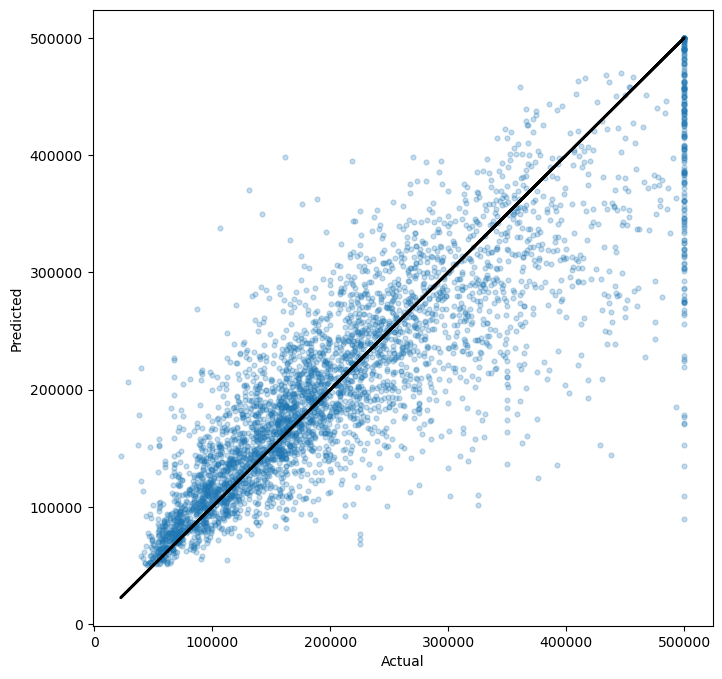

In [132]:

#Make predictions and Plot:
y_pred = model.predict(X_test_prepared)

#Plot:
fig, ax1 = plt.subplots(1,1, figsize=(8, 8))

#Scatter plot of prediction vs. actual
ax1.scatter(y_test, y_pred, s = 12, alpha=.25)

#Perfect prediction line
ax1.plot(y_test, y_test, linewidth=2, color='black')

ax1.set_xlabel('Actual')
ax1.set_ylabel('Predicted')

In [133]:
#Performance on testing data?
####
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

print(r2_score(y_test, y_pred))

print(mean_squared_error(y_test, y_pred, squared=False).round(2))

print(mean_absolute_error(y_test, y_pred).round(2))


0.7372808448850975
59302.18
39823.54


## Pipe Preprocessing + Model Fitting + Hyperparameter Tuning with Cross-Validation

### Full pipeline for Preprocessing + Model Fit/Predict:


In [134]:
#Make the full pipeline:
#####

from sklearn.pipeline import Pipeline

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("knn", KNeighborsRegressor(n_neighbors=10)),
])

#prepared_data_test = preprocessing.transform(X_test)
full_pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms_ratio',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x0...
                                                   'median_income']),
                                                 ('geo', ClusterSimilarity(),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000026F10B03C70>)])),
                ('knn', KNeighborsRegressor(n_neighbors=10))])

In [135]:
#Fit:
full_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms_ratio',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x0...
                                                   'median_income']),
                                                 ('geo', ClusterSimilarity(),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000026F10B03C70>)])),
                ('knn', KNeighborsRegressor(n_neighbors=10))])

In [136]:
#Transform on test data:

y_pred = full_pipeline.predict(X_test)

In [137]:
##Confirm metrics similar:
####

print(r2_score(y_test, y_pred))
print(mean_squared_error(y_test, y_pred, squared=False).round(2))
print(mean_absolute_error(y_test, y_pred).round(2))

0.7372808448850975
59302.18
39823.54


### Now do a Grid Search for Best Hyperparameter


In [138]:
####
from sklearn.model_selection import GridSearchCV

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("knn", KNeighborsRegressor(n_neighbors=10)),
])

param_grid = [{'knn__n_neighbors': range(1, 50, 2)}]

grid_search = GridSearchCV(full_pipeline, param_grid, cv=3, scoring = "neg_root_mean_squared_error")

grid_search.fit(X_train, y_train)


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms_ratio',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_...
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x0000026F10B03C70>)])),
                                       ('knn',
                                        KNeighborsRegressor(n_neighbors=10))]),
             param_grid=[{'knn__n_neighbors': range(1, 50, 2)}],
             scoring='neg_root_mean_squared_error')

In [139]:
##Best params:

grid_search.best_params_

{'knn__n_neighbors': 9}

In [140]:
##Best score?

grid_search.best_score_

-60583.77519648962

#### Phew! Okay, done for now!